In [1]:
import os
import sys
import pandas as pd
import re

import pymystem3
import operator
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
os.environ["PYSPARK_SUBMIT_ARGS"]='--conf spark.sql.catalogImplementation=in-memory pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())


from pyspark.sql.types import *
import pyspark.sql.functions as f

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [3]:
!hadoop fs -ls /labs/lab06data/ml-100k

Found 23 items
-rw-r--r--   3 artem.trunov hdfs       6750 2018-10-08 21:49 /labs/lab06data/ml-100k/README
-rw-r--r--   3 artem.trunov hdfs        716 2018-10-08 21:49 /labs/lab06data/ml-100k/allbut.pl
-rw-r--r--   3 artem.trunov hdfs        643 2018-10-08 21:49 /labs/lab06data/ml-100k/mku.sh
-rw-r--r--   3 artem.trunov hdfs    1979173 2018-10-08 21:49 /labs/lab06data/ml-100k/u.data
-rw-r--r--   3 artem.trunov hdfs        202 2018-10-08 21:49 /labs/lab06data/ml-100k/u.genre
-rw-r--r--   3 artem.trunov hdfs         36 2018-10-08 21:49 /labs/lab06data/ml-100k/u.info
-rw-r--r--   3 artem.trunov hdfs     236344 2018-10-08 21:49 /labs/lab06data/ml-100k/u.item
-rw-r--r--   3 artem.trunov hdfs        193 2018-10-08 21:49 /labs/lab06data/ml-100k/u.occupation
-rw-r--r--   3 artem.trunov hdfs      22628 2018-10-08 21:49 /labs/lab06data/ml-100k/u.user
-rw-r--r--   3 artem.trunov hdfs    1586544 2018-10-08 21:49 /labs/lab06data/ml-100k/u1.base
-rw-r--r--   3 artem.trunov hdfs     392629 2018-10-08

In [4]:
!hadoop fs -cat /labs/lab06data/ml-100k/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

# Read

## u.data

In [5]:
!hadoop fs -cat /labs/lab06data/ml-100k/u.data | head -n 4

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
cat: Unable to write to output stream.


In [7]:
udata_path = '/labs/lab06data/ml-100k/u.data'
udata_schema =  StructType(fields=[
    StructField("user_id", IntegerType()),
    StructField("item_id", IntegerType()),
    StructField("rating", IntegerType()),
    StructField("timestamp", IntegerType())
])
udata = spark.read.csv(path=udata_path, sep='\t', schema=udata_schema)

In [9]:
udata.show(5)

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|    196|    242|     3|881250949|
|    186|    302|     3|891717742|
|     22|    377|     1|878887116|
|    244|     51|     2|880606923|
|    166|    346|     1|886397596|
+-------+-------+------+---------+
only showing top 5 rows



## u.item

In [10]:
!hadoop fs -cat /labs/lab06data/ml-100k/u.item | head -n 4

1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
cat: Unable to write to output stream.


In [11]:
uitem_path = '/labs/lab06data/ml-100k/u.item'

In [12]:
uitem_path = '/labs/lab06data/ml-100k/u.item'
uitem_schema =  StructType(fields=[
    StructField("movie_id", IntegerType()),
    StructField("release_date", StringType()),
    StructField("video_release_date", StringType()),
    StructField("to_del", StringType()),
    StructField("IMDb_url", StringType()),
    StructField("unknown", IntegerType()),
    StructField("Action", IntegerType()),
    StructField("Adventure", IntegerType()),
    StructField("Animation", IntegerType()),
    StructField("Childrens", IntegerType()),
    StructField("Comedy", IntegerType()),
    StructField("Crime", IntegerType()),
    StructField("Drama", IntegerType()),
    StructField("Fantasy", IntegerType()),
    StructField("Film_Noir", IntegerType()),
    StructField("Horror", IntegerType()),
    StructField("Musical", IntegerType()),
    StructField("Mystery", IntegerType()),
    StructField("Romance", IntegerType()),
    StructField("Sci_Fi", IntegerType()),
    StructField("Thriller", IntegerType()),
    StructField("War", IntegerType()),
    StructField("Western", IntegerType())
])
uitem = spark.read.csv(path=uitem_path, sep='|', schema=uitem_schema)

In [14]:
uitem.show(1, False, True)

-RECORD 0-------------------------------------------------------------------
 movie_id           | 1                                                     
 release_date       | Toy Story (1995)                                      
 video_release_date | 01-Jan-1995                                           
 to_del             | null                                                  
 IMDb_url           | http://us.imdb.com/M/title-exact?Toy%20Story%20(1995) 
 unknown            | 0                                                     
 Action             | 0                                                     
 Adventure          | 0                                                     
 Animation          | 1                                                     
 Childrens          | 1                                                     
 Comedy             | 1                                                     
 Crime              | 0                                                     

# Часть1. Основные характеристики данных MovieLens

1. Найдите количество всех пользователей и количество всех фильмов в данных (общее число пользователей и фильмов в датасете).

In [22]:
from pyspark.sql.functions import countDistinct

In [37]:
gr = udata.agg(countDistinct("user_id")).collect()
num_users = gr[0][0]
num_users

943

In [39]:
gr_item = uitem.agg(countDistinct("movie_id")).collect()
num_movies = gr_item[0][0]
num_movies

1682

2. Сколько пользователь в среднем ставит рейтингов? Подсчитать количество рейтингов / количество пользователей. Поле average_user_ratings

In [41]:
average_user_ratings = udata.count()/num_users

In [44]:
average_user_ratings

106.04453870625663

3. Сколько фильм в среднем имеет рейтингов? Подсчитать количество рейтингов / количество фильмов. Поле average_film_ratings

In [42]:
average_film_ratings = udata.count()/num_movies

In [45]:
average_film_ratings

59.45303210463734

4. Найдите процент заполненных ячеек в данных: количество рейтингов / (количество пользователей * количество фильмов). Поле completeness.

In [43]:
completeness = udata.count()/(num_users*num_movies)

In [46]:
completeness

0.06304669364224531

# Часть 2. User-user CF:

1. Для каждого пользователя найдите его средний рейтинг (сумма рейтингов пользователя/количество рейтингов пользователя). Здесь Ia — множество фильмов, по которым у пользователя есть рейтинги rui. Здесь и далее |Ia| обозначает количество элементов в множестве Ia.


In [267]:
from pyspark.sql.functions import col

In [113]:
my_user_id = 94

In [288]:
user_ranks_count = udata.groupBy("user_id").count()
user_ranks_avg = udata.groupBy("user_id").agg({"rating":"sum"})
user_ranks = user_ranks_count.join(user_ranks_avg, on='user_id').select(col("user_id").alias("user_id"), 
                                                                        col("count").alias("rnk_count"), 
                                                                        col("sum(rating)").alias("rnk_sum"))

In [87]:
user_ranks = user_ranks.withColumn('user_avg_rnk', col('rnk_sum')/col('rnk_count'))

In [91]:
my_user = user_ranks.where(col('user_id').isin(my_user_id))

In [122]:
ra = my_user.select('user_avg_rnk').collect()

In [123]:
ra = ra[0][0]
ra

3.6575

2. Посчитайте меру близости Пирсона выданного вам пользователя со всеми остальными пользователями. Обратите внимание, что корреляция Пирсона считается только на пересечении, то есть вклад вносят только фильмы, оцененные совместно (Ia, Iu — множества оцененных пользователями a и u фильмов). Корреляция с константой (ситуация, когда у пользователя все оценки одинаковые) равна нулю.

Формат: ID пользователя; корреляция Пирсона

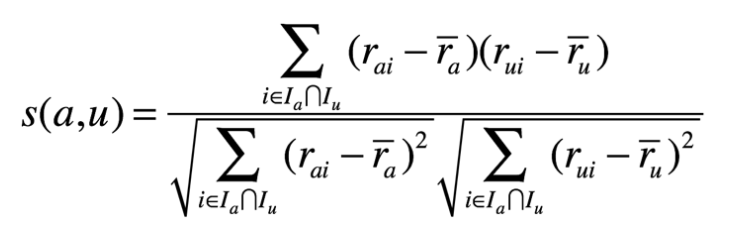

In [98]:
udata_94 = udata.where(col('user_id')==my_user_id)

In [101]:
films = [i.item_id for i in udata_94.select('item_id').distinct().collect()]

In [103]:
udata_for_pirson = udata.where(col('item_id').isin(films))

In [107]:
udata_for_pirson = udata_for_pirson.join(user_ranks, on='user_id', how='left')

In [108]:
udata_for_pirson.show(5)

+-------+-------+------+---------+---------+-------+------------+
|user_id|item_id|rating|timestamp|rnk_count|rnk_sum|user_avg_rnk|
+-------+-------+------+---------+---------+-------+------------+
|    148|      1|     4|877019411|       65|    260|         4.0|
|    148|     70|     5|877021271|       65|    260|         4.0|
|    148|    172|     5|877016513|       65|    260|         4.0|
|    148|    177|     2|877020715|       65|    260|         4.0|
|    148|    185|     1|877398385|       65|    260|         4.0|
+-------+-------+------+---------+---------+-------+------------+
only showing top 5 rows



In [110]:
users = [i.user_id for i in udata_for_pirson.select('user_id').distinct().collect() if i.user_id != my_user_id]

In [168]:
data_tmp = udata_for_pirson.withColumn('corr_rnk', col('rating')-col('user_avg_rnk'))

In [169]:
data_tmp.show(5)

+-------+-------+------+---------+---------+-------+------------+--------+
|user_id|item_id|rating|timestamp|rnk_count|rnk_sum|user_avg_rnk|corr_rnk|
+-------+-------+------+---------+---------+-------+------------+--------+
|    148|      1|     4|877019411|       65|    260|         4.0|     0.0|
|    148|     70|     5|877021271|       65|    260|         4.0|     1.0|
|    148|    172|     5|877016513|       65|    260|         4.0|     1.0|
|    148|    177|     2|877020715|       65|    260|         4.0|    -2.0|
|    148|    185|     1|877398385|       65|    260|         4.0|    -3.0|
+-------+-------+------+---------+---------+-------+------------+--------+
only showing top 5 rows



In [170]:
data_tmp_94 = data_tmp.where(col('user_id').isin([my_user_id]))

data_tmp_94 = data_tmp_94.withColumnRenamed('corr_rnk','corr_rnk_94')\
        .withColumnRenamed('user_id','user_id_94')\
        .select('user_id_94','item_id','corr_rnk_94')

In [171]:
data_mult = data_tmp_94.join(data_tmp, on='item_id', how='inner')\
    .withColumn('mult',f.col('corr_rnk')*f.col('corr_rnk_94'))\
    .groupBy('user_id').agg(
        f.sum(f.col('mult')),
        f.sqrt(f.sum(f.col('corr_rnk')**2)).alias('norm'),
        f.sqrt(f.sum(f.col('corr_rnk_94')**2)).alias('norm_94'),
        f.count(f.col('user_id_94')).alias('count')
    )

In [172]:
data_mult.show()

+-------+-------------------+------------------+------------------+-----+
|user_id|          sum(mult)|              norm|           norm_94|count|
+-------+-------------------+------------------+------------------+-----+
|    148| -6.315000000000007| 7.874007874011811|  6.16833800549224|   47|
|    496|  36.03889534883721|12.079049270707424| 8.147455507703002|   85|
|    833|  86.82283707865173|15.874599323251545| 11.95868565102369|  154|
|    463| 17.330225563909774| 8.054761973972065| 6.785329763541341|   48|
|    471|-7.8361290322580635| 7.596209142741567|4.4944368390266645|   26|
|    243| 13.676635802469127|4.4827396798544825| 6.153418257359075|   41|
|    897| 12.734608108108096|11.087896388006884|11.334571286555127|  129|
|    623|  7.114166666666667| 6.057135369866591|5.6661908501214455|   35|
|    737|  7.322121212121213| 5.564712380268614| 5.442598758865106|   29|
|    392| 18.755495495495495| 6.708814901797171| 6.514328438143106|   44|
|    540| 15.557857142857143|  3.65334

In [176]:
data_pearson = data_mult.withColumn('pearson',\
                    f.least(f.col('count')/50,f.lit(1))*f.col('sum(mult)')/(f.col('norm_94')*f.col('norm')))

In [182]:
neighbours = data_pearson.sort('pearson', ascending = False).take(31)

In [184]:
ngb = [x['user_id'] for x in neighbours]
ngb = ngb[1:]

5. Для всех фильмов найдите прогноз оценки по формуле ниже. Здесь N(a) — множество пользователей-соседей, s(a,u) — мера близости пользователей из предыдущих пунктов, |s(a,u)| — модуль меры близости.

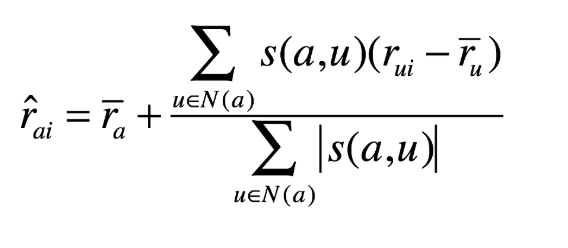

In [277]:
data_pearson = data_pearson.sort('pearson', ascending = False).where(col('user_id').isin(ngb))

In [278]:
neighbours = data_pearson.sort('pearson', ascending = False).where('user_id!=94').limit(30)

In [279]:
neighbours.show(5)

+-------+------------------+-----------------+------------------+-----+------------------+
|user_id|         sum(mult)|             norm|           norm_94|count|           pearson|
+-------+------------------+-----------------+------------------+-----+------------------+
|    397| 33.91161764705882|6.915455835428689| 6.656772397340921|   51|0.7366547382609498|
|    323| 32.11848314606742|6.997898579013296| 7.249954741238045|   55|0.6330705156721718|
|    360|23.760441176470575|5.744428790571782| 6.663355948769358|   50|0.6207470104562197|
|    293|141.31806701030922|16.40684321245584| 14.59860524159757|  236|0.5900126124304435|
|    267| 63.91263513513515| 9.32711278320942|11.734408538567248|  135|0.5839535344843637|
+-------+------------------+-----------------+------------------+-----+------------------+
only showing top 5 rows



In [298]:
user_ranks = user_ranks.withColumn('user_avg_rnk', col('rnk_sum')/col('rnk_count'))
user_ranks.show(5)

+-------+---------+-------+------------------+
|user_id|rnk_count|rnk_sum|      user_avg_rnk|
+-------+---------+-------+------------------+
|    148|       65|    260|               4.0|
|    463|      133|    381|2.8646616541353382|
|    471|       31|    105|3.3870967741935485|
|    496|      129|    391|3.0310077519379846|
|    833|      267|    816| 3.056179775280899|
+-------+---------+-------+------------------+
only showing top 5 rows



In [304]:
udata_upd = udata.join(user_ranks, on='user_id', how='left')

In [300]:
udata_upd.show(5)

+-------+-------+------+---------+---------+-------+------------+
|user_id|item_id|rating|timestamp|rnk_count|rnk_sum|user_avg_rnk|
+-------+-------+------+---------+---------+-------+------------+
|    148|    408|     5|877399018|       65|    260|         4.0|
|    148|      1|     4|877019411|       65|    260|         4.0|
|    148|    140|     1|877019882|       65|    260|         4.0|
|    148|    114|     5|877016735|       65|    260|         4.0|
|    148|     70|     5|877021271|       65|    260|         4.0|
+-------+-------+------+---------+---------+-------+------------+
only showing top 5 rows



In [305]:
udata_upd = udata_upd.withColumn('corr_rnk', col('rating')-col('user_avg_rnk'))

In [306]:
movie_data = udata_upd.join(neighbours, on='user_id', how='inner')

In [307]:
movie_data.count()

6499

In [308]:
final = movie_data.groupBy('item_id').agg(
    (f.lit(ra)+f.sum(f.col('pearson')*f.col('corr_rnk'))/f.sum(f.abs(f.col('pearson')))).alias('movie_rating')
).sort('movie_rating', ascending = False)

In [309]:
final.show(5)

+-------+------------------+
|item_id|      movie_rating|
+-------+------------------+
|   1367| 5.377996894409938|
|   1529| 5.377996894409938|
|    513|5.0362215404150605|
|   1099|5.0027380952380955|
|   1103|4.9877089429641455|
+-------+------------------+
only showing top 5 rows



In [313]:
tt = final.join(data_tmp_94, on = "item_id", how="left").where(data_tmp_94['user_id_94'].isNull())\
                                                .sort('movie_rating', ascending = False).limit(10)

In [317]:
pearson_top10 = [t.item_id for t in tt.select(col('item_id')).collect()]

In [318]:
pearson_top10

[1529, 1367, 513, 1099, 1103, 1080, 493, 320, 611, 902]

In [319]:
result = {
    "average_film_ratings": round(average_film_ratings, 6),
    "average_user_ratings": round(average_user_ratings, 6),
    "completeness": round(completeness, 6),
    "pearson_neighbours": ngb,
    "pearson_top10": pearson_top10
}

In [320]:
import json
with open('../lab08.json', 'w') as outfile:
    json.dump(result, outfile)